# **2. 면접 답변 의도 분석 모델 생성 (interview answer intention analysis)**

## BERT 기반 텍스트 분류 관련 참고 자료

1. Hugging Face 공식 문서
   - https://huggingface.co/docs/transformers/tasks/sequence_classification
   - BERT를 포함한 다양한 트랜스포머 모델을 이용한 시퀀스 분류 작업에 대한 상세한 가이드를 제공

2. Google Colab BERT Fine-Tuning 튜토리얼
   - https://colab.research.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb
   - TensorFlow를 사용하여 BERT 모델을 파인튜닝하는 방법을 단계별로 설명

3. Keras 공식 문서 - BERT를 사용한 텍스트 분류
   - https://keras.io/examples/nlp/text_classification_with_bert/
   - Keras를 사용하여 BERT 모델을 구현하고 텍스트 분류 작업에 적용하는 방법을 설명

4. TensorFlow 공식 블로그 - BERT를 사용한 텍스트 분류
   - https://blog.tensorflow.org/2019/05/transformer-based-models-for-text-classification.html
   - TensorFlow를 사용하여 BERT 기반 모델을 구현하고 텍스트 분류에 적용하는 방법을 설명

5. PyTorch 튜토리얼 - BERT를 사용한 텍스트 분류
   - https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html
   - PyTorch를 사용하여 BERT 모델을 구현하고 감성 분석 작업에 적용하는 방법을 설명

6. Towards Data Science 아티클 - BERT를 사용한 텍스트 분류
   - https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f
   - BERT를 사용한 텍스트 분류 모델 구현에 대한 상세한 설명과 코드 예제를 제공

7. KLUE 공식 GitHub 리포지토리
   - https://github.com/KLUE-benchmark/KLUE
   - 한국어 자연어 이해 평가 벤치마크인 KLUE에 대한 정보와 베이스라인 모델 구현을 제공


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install koreanize_matplotlib
!fc-list | grep NanumGothic
!apt-get install fonts-nanum*dd

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package fonts-nanum*dd
E: Couldn't find any package by glob 'fonts-nanum*dd'
E: Couldn't find any package by regex 'fonts-nanum*dd'


In [ ]:
import koreanize_matplotlib
import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [ ]:
!pip uninstall tensorflow
!pip install tensorflow==2.15.0
!pip install keras==2.15.0
!pip install transformers==4.35.0
!pip install keras-tuner

Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.15.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? ERROR: Operation cancelled by user


In [ ]:
import tensorflow as tf
import keras
import transformers

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"Transformers version: {transformers.__version__}")

TensorFlow version: 2.15.0
Keras version: 2.15.0
Transformers version: 4.35.0


## (1) 토크나이저 테스트

In [ ]:
from transformers import TFBertForMaskedLM, AutoTokenizer

# KLUE BERT 모델과 토크나이저 로드
model_name = "klue/bert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFBertForMaskedLM.from_pretrained(model_name, from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForMaskedLM: ['bert.embeddings.position_ids', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing TFBertForMaskedLM from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForMaskedLM from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertForMaskedLM were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


In [ ]:
# 모델 로딩 확인
print("토크나이저 정보:", tokenizer)
print("KLUE 모델 정보:", model)

토크나이저 정보: BertTokenizerFast(name_or_path='klue/bert-base', vocab_size=32000, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
KLUE 모델 정보: <transformers.models.bert.modeling_tf_bert.TFBertForMaskedLM object at 0x7d3871df7df0>


In [ ]:
# 입력 문장
sample_text = "저는 항상 긍정적이고 [MASK]이 강합니다."

# 텍스트를 토큰화
inputs = tokenizer(sample_text, return_tensors='tf')

# 모델 예측
outputs = model(**inputs)
logits = outputs.logits

# 마스크된 토큰의 인덱스 찾기
mask_token_index = tf.where(inputs["input_ids"] == tokenizer.mask_token_id)[0][1]

# 마스크된 토큰에 대한 예측
mask_token_logits = logits[0, mask_token_index, :]

# 가장 높은 확률을 가진 토큰의 인덱스
top_5_tokens = tf.math.top_k(mask_token_logits, 5).indices.numpy()

# 예측된 토큰을 디코딩하여 출력
predicted_tokens = [tokenizer.decode([token]) for token in top_5_tokens]
print("예측된 토큰들:", predicted_tokens)

예측된 토큰들: ['자신감', '책임감', '열정', '자부심', '긍정']


## (2) 데이터 로드 및 전처리

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# 파일 경로 설정 및 데이터 로드
train_file_path = "/content/drive/MyDrive/Colab Notebooks/Project(InterviewData-Analysis)/data/intent_answers_Training.tsv"
validation_file_path = "/content/drive/MyDrive/Colab Notebooks/Project(InterviewData-Analysis)/data/intent_answers_Validation.tsv"

train_df = pd.read_csv(train_file_path, sep="\t")
validation_df = pd.read_csv(validation_file_path, sep="\t")

print("Train 데이터 샘플:")
print(train_df.head())
print("\nValidation 데이터 샘플:")
print(validation_df.head())

Train 데이터 샘플:
   id                                           document  label
0   0              저는 늘 여러 사람에게 해당 문제를 터놓고 조언을 구하는 편입니다.     21
1   1  제 단점은 새로운 것에 항상 눈이 번쩍이고 또 음 그걸 끈기가 부족한 점인데 이 끈...     21
2   2                           일단 장점은 어 편안함이라고 생각을 합니다.     21
3   3              제 단점은 음 저는 참 지속성 끈기가 좀 부족하다고 생각을 합니다.     21
4   4  거기에 대한 저의 답변입니다, 저는 성격이 모나지 않아서 주변 사람하고 별 탈 없이...     21

Validation 데이터 샘플:
   id                                           document  label
0   0           이 직무를 수행하기 위해서 저의 강점은 커뮤니케이션이 잘 된다는 겁니다.     25
1   1  흔히 열심히 하는 것보다 잘하고 효율적으로 하는 것은 보다 많은 업무적 성과나 업무...     25
2   2  어 최근에는 이제 이웃 간의 이제 다툼   다툼에서 발행 발생되는 살인 저 그거에 ...     25
3   3   이 직무와 관련한 자신의 강점은 이제 창의력이라고 생각합니다. 어 어떤 일이든  ...     25
4   4  저를 일단 직무 체험을 되게 열심히 합니다. 그리고 청년 인턴 또 과 청년 인턴도 ...     25


In [ ]:
# 데이터 전처리
# 'document'와 'label' 열만 선택
train_df = train_df.iloc[:, [1, 2]]
validation_df = validation_df.iloc[:, [1, 2]]

In [ ]:
train_df.head()

,document,label
0,저는 늘 여러 사람에게 해당 문제를 터놓고 조언을 구하는 편입니다.,21
1,제 단점은 새로운 것에 항상 눈이 번쩍이고 또 음 그걸 끈기가 부족한 점인데 이 끈...,21
2,일단 장점은 어 편안함이라고 생각을 합니다.,21
3,제 단점은 음 저는 참 지속성 끈기가 좀 부족하다고 생각을 합니다.,21
4,"거기에 대한 저의 답변입니다, 저는 성격이 모나지 않아서 주변 사람하고 별 탈 없이...",21


In [ ]:
validation_df.head()

,document,label
0,이 직무를 수행하기 위해서 저의 강점은 커뮤니케이션이 잘 된다는 겁니다.,25
1,흔히 열심히 하는 것보다 잘하고 효율적으로 하는 것은 보다 많은 업무적 성과나 업무...,25
2,어 최근에는 이제 이웃 간의 이제 다툼 다툼에서 발행 발생되는 살인 저 그거에 ...,25
3,이 직무와 관련한 자신의 강점은 이제 창의력이라고 생각합니다. 어 어떤 일이든 ...,25
4,저를 일단 직무 체험을 되게 열심히 합니다. 그리고 청년 인턴 또 과 청년 인턴도 ...,25


In [ ]:
# 샘플 수 조정 (첫 번째 샘플 제외)
train_df = train_df.iloc[1:].reset_index(drop=True)
validation_df = validation_df.iloc[1:].reset_index(drop=True)

print("전처리 후 Train 데이터 샘플:")
print(train_df.head())
print("\n전처리 후 Validation 데이터 샘플:")
print(validation_df.head())

전처리 후 Train 데이터 샘플:
                                            document  label
0  제 단점은 새로운 것에 항상 눈이 번쩍이고 또 음 그걸 끈기가 부족한 점인데 이 끈...     21
1                           일단 장점은 어 편안함이라고 생각을 합니다.     21
2              제 단점은 음 저는 참 지속성 끈기가 좀 부족하다고 생각을 합니다.     21
3  거기에 대한 저의 답변입니다, 저는 성격이 모나지 않아서 주변 사람하고 별 탈 없이...     21
4                   항상 잘 웃고 주변을 편하게 해 주는 게 저의 장점입니다.     21

전처리 후 Validation 데이터 샘플:
                                            document  label
0  흔히 열심히 하는 것보다 잘하고 효율적으로 하는 것은 보다 많은 업무적 성과나 업무...     25
1  어 최근에는 이제 이웃 간의 이제 다툼   다툼에서 발행 발생되는 살인 저 그거에 ...     25
2   이 직무와 관련한 자신의 강점은 이제 창의력이라고 생각합니다. 어 어떤 일이든  ...     25
3  저를 일단 직무 체험을 되게 열심히 합니다. 그리고 청년 인턴 또 과 청년 인턴도 ...     25
4      그리고 직무 직무 체험과   청년인턴 등 어 지원하기 위해 많은 노력을 했습니다.     25


In [ ]:
# 기본 데이터 분석
print(f"Train 데이터셋 크기: {len(train_df)}")
print(f"Validation 데이터셋 크기: {len(validation_df)}")

num_classes_train = train_df['label'].nunique()
num_classes_val = validation_df['label'].nunique()
print(f"Train 데이터셋의 클래스 수: {num_classes_train}")
print(f"Validation 데이터셋의 클래스 수: {num_classes_val}")

Train 데이터셋 크기: 26017
Validation 데이터셋 크기: 4889
Train 데이터셋의 클래스 수: 52
Validation 데이터셋의 클래스 수: 51


In [ ]:
# 클래스 불일치 확인 및 처리
if num_classes_train != num_classes_val:
    print("경고: Train과 Validation 데이터셋의 클래스 수가 일치하지 않습니다.")
    print("Validation 데이터셋에 없는 클래스:", set(train_df['label']) - set(validation_df['label']))

    # 전체 데이터를 합치고 재분할
    all_data = pd.concat([train_df, validation_df], axis=0)

    # Stratified K-Fold를 사용하여 데이터 재분할
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for train_index, val_index in skf.split(all_data, all_data['label']):
        train_df = all_data.iloc[train_index]
        validation_df = all_data.iloc[val_index]
        break  # 첫 번째 분할만 사용

    # 클래스 수 재확인
    num_classes_train = train_df['label'].nunique()
    num_classes_val = validation_df['label'].nunique()
    print(f"재분할 후 Train 데이터셋의 클래스 수: {num_classes_train}")
    print(f"재분할 후 Validation 데이터셋의 클래스 수: {num_classes_val}")

total_num_classes = max(num_classes_train, num_classes_val)
print(f"전체 클래스 수: {total_num_classes}")

경고: Train과 Validation 데이터셋의 클래스 수가 일치하지 않습니다.
Validation 데이터셋에 없는 클래스: {48}
재분할 후 Train 데이터셋의 클래스 수: 52
재분할 후 Validation 데이터셋의 클래스 수: 52
전체 클래스 수: 52


In [ ]:
# 클래스 분포 확인
print("\nTrain 데이터셋 클래스 분포:")
print(train_df['label'].value_counts())
print("\nValidation 데이터셋 클래스 분포:")
print(validation_df['label'].value_counts())


Train 데이터셋 클래스 분포:
label
22    4014
21    3974
29    1929
28    1752
25    1418
23    1233
45    1065
44     963
30     886
43     709
26     701
24     525
33     371
27     357
42     356
34     277
41     263
36     248
19     240
16     226
39     224
50     205
35     204
32     200
6      194
12     188
18     174
51     150
9      143
3      141
2      132
49     126
40     120
31     106
14      80
20      78
8       72
38      63
13      63
11      63
7       60
37      52
4       48
10      47
15      44
46      41
17      40
5       40
47      39
0       39
1       29
48      12
Name: count, dtype: int64

Validation 데이터셋 클래스 분포:
label
22    1003
21     994
29     482
28     438
25     354
23     309
45     266
44     241
30     221
43     178
26     175
24     131
33      92
27      90
42      90
34      70
41      66
19      61
36      61
39      56
16      56
50      51
35      51
32      50
6       49
12      47
18      43
51      37
3       35
9       35
2       33
49  

In [ ]:
# 가장 적은 수의 샘플을 가진 클래스 확인
min_samples_train = train_df['label'].value_counts().min()
min_samples_val = validation_df['label'].value_counts().min()
print(f"\n가장 적은 샘플 수 (Train): {min_samples_train}")
print(f"가장 적은 샘플 수 (Validation): {min_samples_val}")


가장 적은 샘플 수 (Train): 12
가장 적은 샘플 수 (Validation): 2


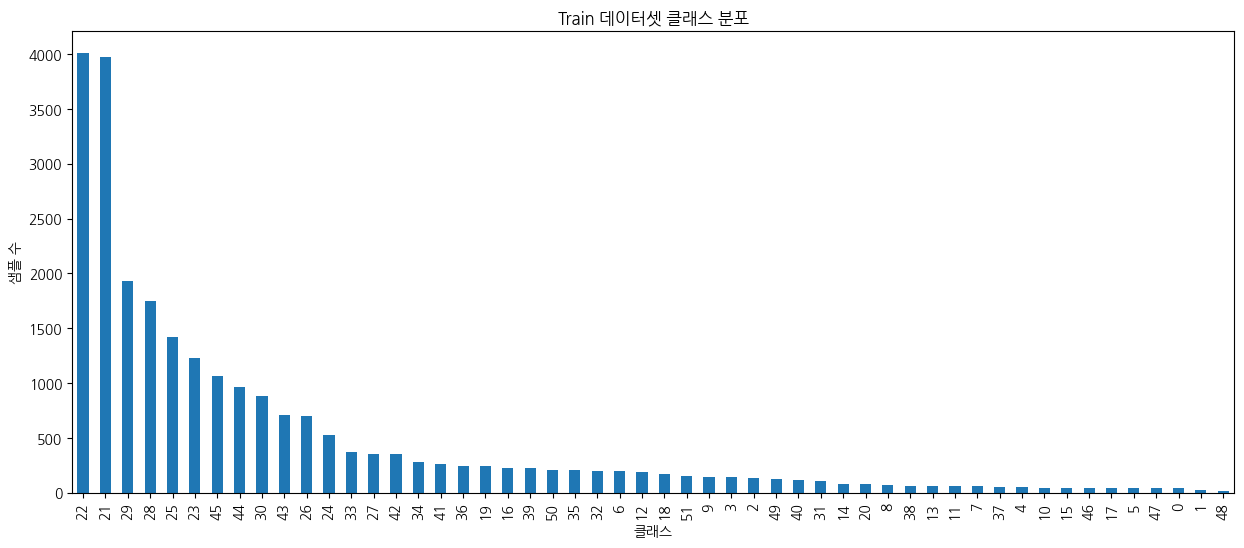

In [ ]:
# 클래스 분포 시각화
plt.figure(figsize=(15, 6))
train_df['label'].value_counts().plot(kind='bar')
plt.title('Train 데이터셋 클래스 분포')
plt.xlabel('클래스')
plt.ylabel('샘플 수')
plt.show()

In [ ]:
# 레이블 인코딩
label_encoder = LabelEncoder()
train_df = train_df.copy()  # 명시적으로 복사본 생성
validation_df = validation_df.copy()  # 명시적으로 복사본 생성

train_df.loc[:, 'encoded_label'] = label_encoder.fit_transform(train_df['label'])
validation_df.loc[:, 'encoded_label'] = label_encoder.transform(validation_df['label'])

# 인코딩된 레이블 확인
print("\n인코딩된 레이블 예시 (훈련 데이터):")
print(train_df[['label', 'encoded_label']].head())

# 레이블 인코딩 매핑 확인
print("\n레이블 인코딩 매핑:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label}: {i}")


인코딩된 레이블 예시 (훈련 데이터):
   label  encoded_label
1     21             21
2     21             21
3     21             21
4     21             21
5     21             21

레이블 인코딩 매핑:
0: 0
1: 1
2: 2
3: 3
4: 4
5: 5
6: 6
7: 7
8: 8
9: 9
10: 10
11: 11
12: 12
13: 13
14: 14
15: 15
16: 16
17: 17
18: 18
19: 19
20: 20
21: 21
22: 22
23: 23
24: 24
25: 25
26: 26
27: 27
28: 28
29: 29
30: 30
31: 31
32: 32
33: 33
34: 34
35: 35
36: 36
37: 37
38: 38
39: 39
40: 40
41: 41
42: 42
43: 43
44: 44
45: 45
46: 46
47: 47
48: 48
49: 49
50: 50
51: 51


In [ ]:
# 인코딩된 레이블 분포 확인
print("\n인코딩된 레이블 분포 (훈련 데이터):")
print(train_df['encoded_label'].value_counts())

print("\n인코딩된 레이블 분포 (검증 데이터):")
print(validation_df['encoded_label'].value_counts())

# 총 클래스 수 재확인
num_classes = len(label_encoder.classes_)
print(f"\n총 클래스 수: {num_classes}")

# 인코딩된 레이블의 범위 확인
print(f"인코딩된 레이블 범위: {train_df['encoded_label'].min()} ~ {train_df['encoded_label'].max()}")


인코딩된 레이블 분포 (훈련 데이터):
encoded_label
22    4014
21    3974
29    1929
28    1752
25    1418
23    1233
45    1065
44     963
30     886
43     709
26     701
24     525
33     371
27     357
42     356
34     277
41     263
36     248
19     240
16     226
39     224
50     205
35     204
32     200
6      194
12     188
18     174
51     150
9      143
3      141
2      132
49     126
40     120
31     106
14      80
20      78
8       72
38      63
13      63
11      63
7       60
37      52
4       48
10      47
15      44
46      41
17      40
5       40
47      39
0       39
1       29
48      12
Name: count, dtype: int64

인코딩된 레이블 분포 (검증 데이터):
encoded_label
22    1003
21     994
29     482
28     438
25     354
23     309
45     266
44     241
30     221
43     178
26     175
24     131
33      92
27      90
42      90
34      70
41      66
19      61
36      61
39      56
16      56
50      51
35      51
32      50
6       49
12      47
18      43
51      37
3       35
9       3

In [ ]:
# 텍스트 데이터 기본 통계
train_df['text_length'] = train_df['document'].str.len()
validation_df['text_length'] = validation_df['document'].str.len()

print("\n훈련 데이터 텍스트 길이 통계:")
print(train_df['text_length'].describe())

print("\n검증 데이터 텍스트 길이 통계:")
print(validation_df['text_length'].describe())


훈련 데이터 텍스트 길이 통계:
count    24724.000000
mean        84.826363
std         52.612891
min          3.000000
25%         48.000000
50%         71.000000
75%        107.000000
max        497.000000
Name: text_length, dtype: float64

검증 데이터 텍스트 길이 통계:
count    6182.000000
mean       84.310903
std        51.020459
min         8.000000
25%        48.000000
50%        72.000000
75%       107.000000
max       502.000000
Name: text_length, dtype: float64


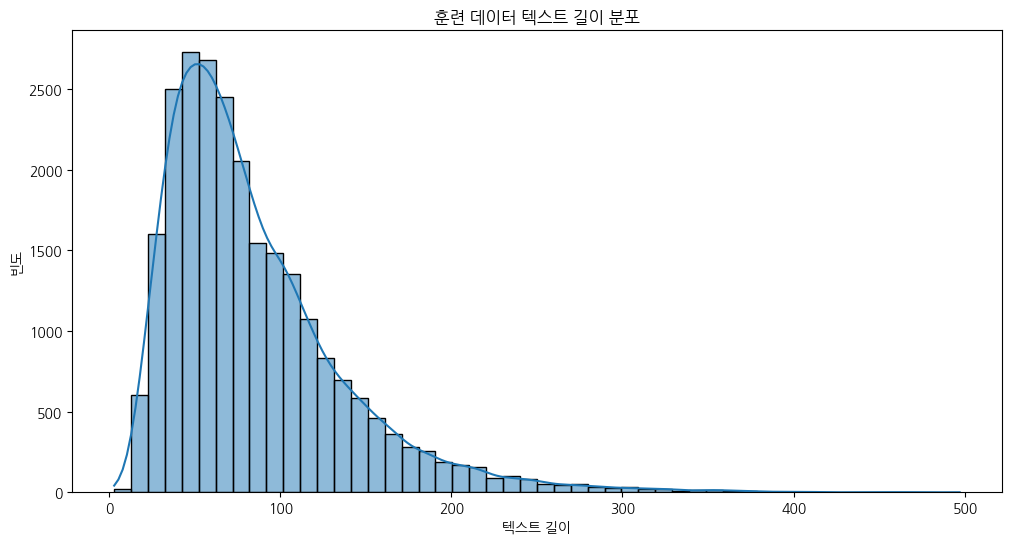

In [ ]:
# 텍스트 길이 분포 시각화
plt.figure(figsize=(12, 6))
sns.histplot(train_df['text_length'], bins=50, kde=True)
plt.title('훈련 데이터 텍스트 길이 분포')
plt.xlabel('텍스트 길이')
plt.ylabel('빈도')
plt.show()

## (3) BERT 모델을 사용하여 텍스트 분류 작업 수행

1. BERT 모델 사용  
- 원본 논문: "BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding" (Devlin et al., 2018)
- 논문 관련 리뷰 : https://velog.io/@pyopyo/BERT-Pre-training-of-Deep-Bidirectional-Transformers-for-Language-Understanding

2. Global Average Pooling과 BERT의 [CLS] 토큰 출력 결합
- "How to Fine-Tune BERT for Text Classification?" (Sun et al., 2019)에서 이러한 접근 방식의 효과성을 보여줌  

3. 잔차 연결(Residual Connection)  
- "Deep Residual Learning for Image Recognition" (He et al., 2016)에서 처음 소개되었으며, 이후 다양한 자연어 처리 태스크에도 적용
- 논문 관련 리뷰 : https://mole-starseeker.tistory.com/12

4. 점진적으로 줄어들었다가 다시 늘어나는 Dense 레이어 구조  
- 이는 오토인코더의 개념에서 영감을 받았으며, "Stacked Denoising Autoencoders: Learning Useful Representations in a Deep Network with a Local Denoising Criterion" (Vincent et al., 2010)과 같은 연구에서 그 효과성이 입증되었음

5. GELU 활성화 함수
- "Gaussian Error Linear Units (GELUs)" (Hendrycks & Gimpel, 2016)에서 소개되었으며, BERT를 포함한 여러 최신 모델에서 사용

6. AdamW 최적화 알고리즘
- "Decoupled Weight Decay Regularization" (Loshchilov & Hutter, 2017)에서 제안

In [ ]:
!pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.7 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.3.1 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
import tensorflow as tf
from transformers import TFBertModel, AutoTokenizer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# 하이퍼파라미터 설정
max_len = 128
batch_size = 16  # 배치 크기 감소
learning_rate = 2e-5  # 학습률 조정
epochs = 30
num_classes = 52

In [ ]:
# 훈련 및 검증 데이터 준비
train_texts = train_df['document'].tolist()
train_labels = train_df['encoded_label'].tolist()
validation_texts = validation_df['document'].tolist()
validation_labels = validation_df['encoded_label'].tolist()

In [ ]:
# 클래스 가중치 계산 함수 정의)
def get_class_weights(labels):
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(labels),
        y=labels
    )
    return dict(enumerate(class_weights))

# 클래스 가중치 계산
class_weights = get_class_weights(train_labels)

In [ ]:
# 토크나이저 및 BERT 모델 로드
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")
bert_model = TFBertModel.from_pretrained("klue/bert-base")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['bert.embeddings.position_ids', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already u

In [ ]:
# 토큰화 함수 정의
def tokenize_data(texts, labels):
    inputs = tokenizer(
        texts,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )
    dataset = tf.data.Dataset.from_tensor_slices((dict(inputs), labels))
    return dataset

In [ ]:
# 훈련 및 검증 데이터셋 생성
train_dataset = tokenize_data(train_texts, train_labels).shuffle(1000).batch(batch_size)
validation_dataset = tokenize_data(validation_texts, validation_labels).batch(batch_size)

In [ ]:
# 입력 정의
input_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

# BERT 레이어
bert_outputs = bert_model(input_ids, attention_mask=attention_mask)
sequence_output = bert_outputs.last_hidden_state
pooled_output = bert_outputs.pooler_output

# Global Average Pooling
gap_output = tf.keras.layers.GlobalAveragePooling1D()(sequence_output)

# Concatenate pooled output and GAP output
concatenated = tf.keras.layers.Concatenate()([pooled_output, gap_output])

# Dense layers with residual connections
x = tf.keras.layers.Dense(256, activation='gelu', kernel_regularizer=l2(1e-5))(concatenated)
x = tf.keras.layers.Dropout(0.2)(x)
residual = x

x = tf.keras.layers.Dense(128, activation='gelu', kernel_regularizer=l2(1e-5))(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation='gelu', kernel_regularizer=l2(1e-5))(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Concatenate()([x, residual])  # Residual connection

# Output layer
output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

# 모델 정의
custom_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

In [ ]:
# 학습률 스케줄러 정의
num_train_steps = len(train_dataset) * epochs
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=learning_rate,
    decay_steps=num_train_steps,
    end_learning_rate=0.0
)

In [ ]:
# 옵티마이저 정의
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, weight_decay=0.01)

In [ ]:
# 모델 컴파일
custom_model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# 모델 구조 확인
custom_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1106173   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   44         'attention_mask[0][0]']      
                             hidden_state=(None, 128, 7                                       

In [ ]:
# 모델 저장 경로
model_path = '/content/drive/MyDrive/Colab Notebooks/Project(InterviewData-Analysis)/Models/best_intent_model.h5'

In [ ]:
# 콜백 함수 정의
checkpoint = ModelCheckpoint(
    model_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='auto',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    mode='min',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

callbacks = [checkpoint, early_stopping, reduce_lr]

In [ ]:
# 모델 훈련
history = custom_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=callbacks,
    class_weight=class_weights
)

Epoch 1/30
1546/1546 [==============================] - ETA: 0s - loss: 2.0376 - accuracy: 0.7088
Epoch 1: val_accuracy improved from -inf to 0.32287, saving model to /content/drive/MyDrive/Colab Notebooks/Project(InterviewData-Analysis)/Models/best_intent_model.h5
1546/1546 [==============================] - 759s 464ms/step - loss: 2.0376 - accuracy: 0.7088 - val_loss: 2.5985 - val_accuracy: 0.3229 - lr: 1.9334e-05
Epoch 2/30
1546/1546 [==============================] - ETA: 0s - loss: 1.0813 - accuracy: 0.7879
Epoch 2: val_accuracy improved from 0.32287 to 0.48253, saving model to /content/drive/MyDrive/Colab Notebooks/Project(InterviewData-Analysis)/Models/best_intent_model.h5
1546/1546 [==============================] - 721s 467ms/step - loss: 1.0813 - accuracy: 0.7879 - val_loss: 1.9929 - val_accuracy: 0.4825 - lr: 1.8667e-05
Epoch 3/30
1546/1546 [==============================] - ETA: 0s - loss: 0.6906 - accuracy: 0.8338
Epoch 3: val_accuracy improved from 0.48253 to 0.54254, sav

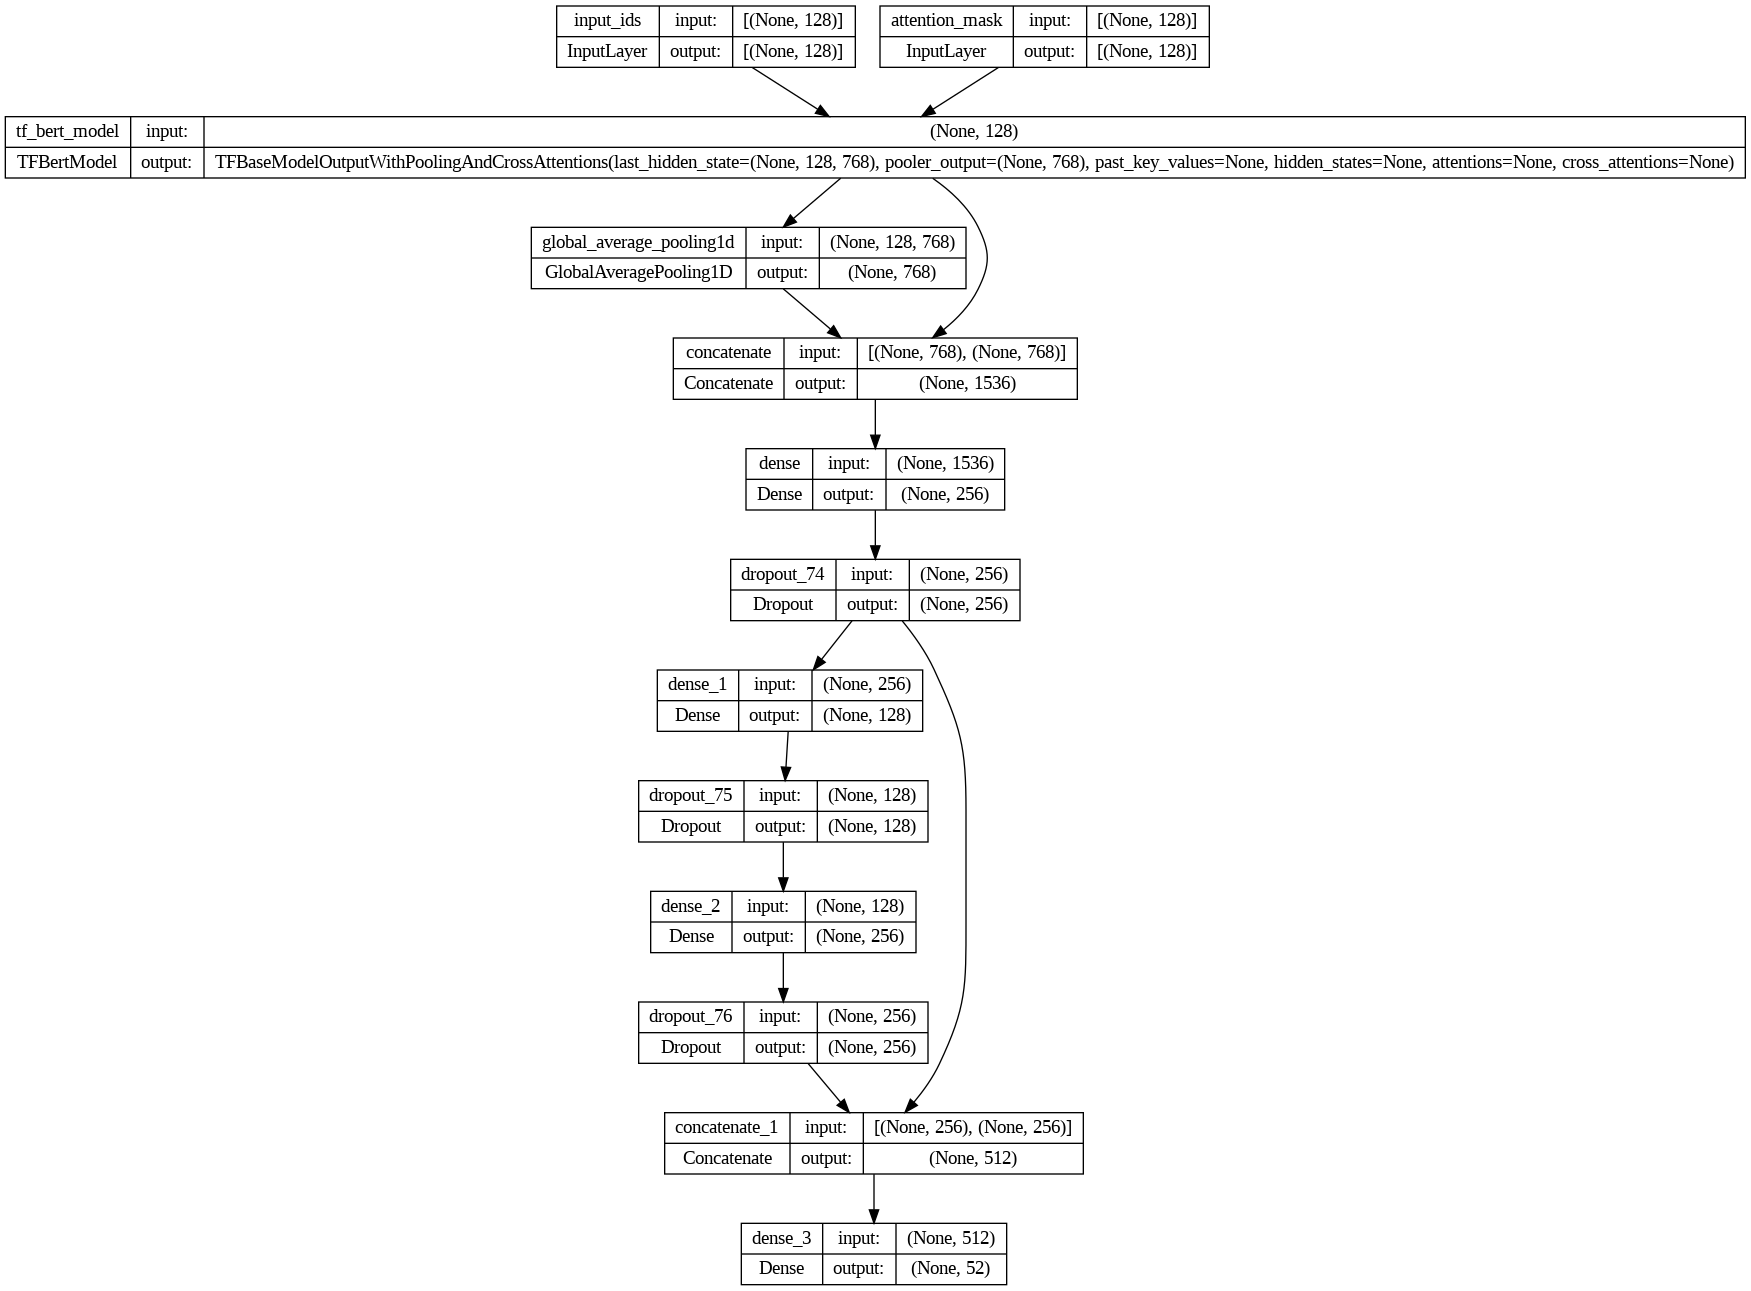

In [ ]:
from tensorflow.keras.utils import plot_model

# 모델 구조 시각화
plot_model(custom_model, to_file='/content/drive/MyDrive/Colab Notebooks/Project(InterviewData-Analysis)/Models/custom_model_structure.png', show_shapes=True, show_layer_names=True)

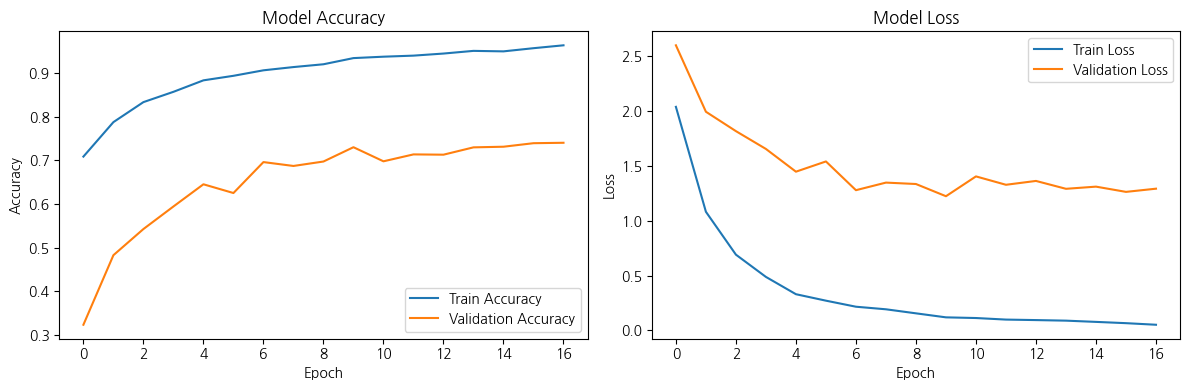

Final Training Accuracy: 0.9642
Final Validation Accuracy: 0.7405
Final Training Loss: 0.0518
Final Validation Loss: 1.2918


In [ ]:
# 훈련 결과 시각화
plt.figure(figsize=(12, 4))

# 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 최종 정확도와 손실 출력
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")